In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

VER = 406
USE = 'carts'

# EARLY STOPPING?
VALIDATE = True

CT = 100

In [2]:
import pandas as pd, cudf, numpy as np, gc
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt

In [3]:
users = pd.read_parquet(f'../../data/train_with_features/train_v174_X.pqt')
#users = users.iloc[:2000]
print (users.shape )
users.head()

(23388700, 226)


,user,item,pos,wgt,carts,score_1,score_3,score_4,score_5,score_6,score_7,score_10,score_11,score_12,score_13,score_30,score_14,score_15,score_16,score_17,score_18,score_19,score_20,score_21,score_22,score_23,score_24,score_25,score_26,buy_ratio_5,count_item_5,count_user_5,repeat_5,buy_ratio_std_5,item_day_std_5,user_day_std_5,buy_ratio_0_6,buy_ratio_1_6,buy_ratio_2_6,buy_ratio_3_6,buy_ratio_4_6,buy_ratio_5_6,buy_ratio_6_6,count_item_0_6,count_item_1_6,count_item_2_6,count_item_3_6,count_item_4_6,count_item_5_6,count_item_6_6,count_user_0_6,count_user_1_6,count_user_2_6,count_user_3_6,count_user_4_6,count_user_5_6,count_user_6_6,item_day_std_6,user_day_std_6,buy_ratio,count_item,count_user,hour_mean,day_mean,repeat,buy_ratio_std,hour_std,day_std,buy_ratio3,count_item3,count_user3,hour_mean3,day_mean3,repeat3,buy_ratio_std3,hour_std3,day_std3,prev3,next3,orders3,carts3,order_repeat3,cart_repeat3,buy_ratio2,count_item2,unique_item2,hour_mean2,day_mean2,repeat2,buy_ratio_std2,hour_std2,day_std2,ts_max7,ts_min7,ts_diff7,z1,z2,z3,z4,z5,z6,buy_ratio7,count_item7,count_user7,hour_mean7,day_mean7,repeat7,buy_ratio_std7,hour_std7,day_std7,prev7,next7,orders7,carts7,order_repeat7,cart_repeat7,buy_ratio8,count_item8,count_user8,hour_mean8,day_mean8,repeat8,buy_ratio_std8,hour_std8,day_std8,prev8,next8,orders8,carts8,order_repeat8,cart_repeat8,buy_ratio9,count_item9,count_user9,hour_mean9,day_mean9,repeat9,buy_ratio_std9,hour_std9,day_std9,prev9,next9,orders9,carts9,order_repeat9,cart_repeat9,buy_ratio10,count_item10,unique_item10,hour_mean10,day_mean10,repeat10,buy_ratio_std10,hour_std10,day_std10,z10,z11,buy_ratio11,count_item11,count_user11,hour_mean11,day_mean11,repeat11,buy_ratio_std11,hour_std11,day_std11,buy_ratio12,count_item12,count_user12,hour_mean12,day_mean12,repeat12,buy_ratio_std12,hour_std12,day_std12,buy_ratio13,count_item13,count_user13,hour_mean13,day_mean13,repeat13,buy_ratio_std13,hour_std13,day_std13,buy_ratio14,count_item14,unique_item14,hour_mean14,day_mean14,repeat14,buy_ratio_std14,hour_std14,day_std14,buy_ratio15,count_item15,unique_item15,hour_mean15,day_mean15,repeat15,buy_ratio_std15,hour_std15,day_std15,last_0,last_1,last_2,last_3,last_4,first_0,first_1,first_2,first_3,first_4,buy_0,buy_1,buy_2,buy_3,buy_4,e_mean_0,e_std_0,e_mean_1,e_std_1,e_mean_2,e_std_2,e_mean_3,e_std_3,click_oof
0,11098533,1165015,0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.600000,-1.0,2.200000,-1.0,-1.0,1.500000,1.600000,1.500000,1.500000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.116279,86.0,58.0,1.482759,0.357067,6.755245,6.755245,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.307692,1.0,-1.0,1.0,-1.0,1.0,-1.0,13.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,7.0,4.750940,4.750940,0.136364,154.0,99.0,56034.429688,321966.906250,1.555556,0.397183,17312.884766,153317.859375,0.250000,16.0,10.0,57562.187500,300562.18750,1.600000,0.577350,22206.015625,82783.578125,10.0,9.0,1.0,2.0,1.000000,1.000000,0.117647,17.0,13.0,38353.824219,373789.125,1.307692,0.332106,15429.47168,13270.989258,40415,1,40414,1.000000,0.987719,0.947001,-1.0,-1.0,-1.0,0.076190,105.0,78.0,56847.656250,318516.218750,1.346154,0.300488,16512.648438,167820.515625,77.0,69.0,1.0,6.0,3.0,6.000000,0.159574,94.0,64.0,67433.125000,314684.18750,1.468750,0.422567,11249.509766,159400.546875,71.0,65.0,2.0,11.0,2.5,2.142857,0.100000,60.0,38.0,38176.464844,333376.468750,1.578947,0.354152,6817.803223,143838.656250,38.0,43.0,1.0,4.0,-1.0,-1.000000,1.0,2.0,2.0,79339.5,338539.5,1.0,0.0,195.868576,195.868576,0.987719,1.0,1.166667,18.0,13.0,62896.667969,336496.656250,1.384615,0.383482,16853.607422,144629.515625,1.333333,3.0,2.0,67674.335938,269274.343750,1.500000,0.577350,24975.738281,24909.345703,1.333333,3.0,2.0,67674.335938,269274.34375,1.5,0.57735,24975.738281,24909.345703,0.117647,17.0,13.0,38353.824219,373789.125,1.307692,0.332106,15429.47168,13270.989258,1.0,2.0,2.0,79339.5,338539.5,1.0,0.0,195.868576,195.868576,1.000000,0.732554,0.788323,0.805929,0.637763,0.739908,0.805929,0.805929,0.656059,0

# XGBoost

In [4]:
FEATURES = users.columns[2:]
TARS = [USE]
FEATURES = [f for f in FEATURES if f not in TARS]
print(len(FEATURES))
print( FEATURES)
print(TARS)
#222

223
['pos', 'wgt', 'score_1', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_10', 'score_11', 'score_12', 'score_13', 'score_30', 'score_14', 'score_15', 'score_16', 'score_17', 'score_18', 'score_19', 'score_20', 'score_21', 'score_22', 'score_23', 'score_24', 'score_25', 'score_26', 'buy_ratio_5', 'count_item_5', 'count_user_5', 'repeat_5', 'buy_ratio_std_5', 'item_day_std_5', 'user_day_std_5', 'buy_ratio_0_6', 'buy_ratio_1_6', 'buy_ratio_2_6', 'buy_ratio_3_6', 'buy_ratio_4_6', 'buy_ratio_5_6', 'buy_ratio_6_6', 'count_item_0_6', 'count_item_1_6', 'count_item_2_6', 'count_item_3_6', 'count_item_4_6', 'count_item_5_6', 'count_item_6_6', 'count_user_0_6', 'count_user_1_6', 'count_user_2_6', 'count_user_3_6', 'count_user_4_6', 'count_user_5_6', 'count_user_6_6', 'item_day_std_6', 'user_day_std_6', 'buy_ratio', 'count_item', 'count_user', 'hour_mean', 'day_mean', 'repeat', 'buy_ratio_std', 'hour_std', 'day_std', 'buy_ratio3', 'count_item3', 'count_user3', 'hour_mean3', 'day

In [5]:
# LOAD XGB LIBRARY
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
print('XGB Version',xgb.__version__)

FOLDS = 5
SEED = 42

LR = 0.1

# XGB MODEL PARAMETERS
xgb_parms = { 
    'max_depth':4, 
    'learning_rate':LR, 
    'subsample':0.7,
    'colsample_bytree':0.5, 
    'eval_metric':'map',
    'objective':'rank:pairwise',
    #'scale_pos_weight':1.5,
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

XGB Version 1.5.2


In [6]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [7]:
%%time
USE_LOADER = True

oof = np.zeros(len(users))
importances = []
importances2 = []

skf = GroupKFold(n_splits=FOLDS)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            X=users, y=users[USE], groups=users.user )):
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size BEFORE',len(train_idx),'Valid size',len(valid_idx))
    #train_idxA = users[[USE]].loc[(users.index.isin(train_idx2))&(users[USE]==1)].index.values
    #train_idxB = users[[USE]].loc[(users.index.isin(train_idx2))&(users[USE]==0)].sample(frac=0.85).index.values
    #train_idx = np.sort( np.concatenate([train_idxA,train_idxB]) )
    #print('### Train size AFTER',len(train_idx),'Valid size',len(valid_idx))
    #USR = users.loc[train_idx,'user'].unique() #maintains row order
    #GRPS = users.loc[train_idx,['user']].groupby('user').user.count().loc[USR].values
    GRPS = [CT] * ( len(train_idx)//CT )
    #print('### number of groups',len(USR))
    print('#'*25)
    
    # TRAIN, VALID, HOLDOUT FOR FOLD K
    if USE_LOADER:
        Xy_train = IterLoadForDMatrix(users.loc[train_idx], FEATURES, USE)
        if VALIDATE:
            Xy_valid = IterLoadForDMatrix(users.loc[valid_idx], FEATURES, USE)
    else:
        X_train = users.loc[train_idx, FEATURES]
        y_train = users.loc[train_idx,USE]
        if VALIDATE:
            X_valid = users.loc[valid_idx, FEATURES]
            y_valid = users.loc[valid_idx, USE]
            
    if USE_LOADER:
        dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
        dtrain.set_group( GRPS )
        #dtrain.set_group( [CT] * ( len(train_idx)//CT) )
        if VALIDATE:
            dvalid = xgb.DeviceQuantileDMatrix(Xy_valid, max_bin=256)
            dvalid.set_group( [CT] * ( len(valid_idx)//CT) )
    else:
        #dtrain = xgb.DMatrix(data=X_train, label=y_train, group=[CT] * (len(train_idx)//CT) )
        dtrain = xgb.DMatrix(data=X_train, label=y_train, group=GRPS )
        if VALIDATE:
            dvalid = xgb.DMatrix(data=X_valid, label=y_valid, group=[CT] * (len(valid_idx)//CT) )

    if VALIDATE:
        dd = [(dtrain,'train'),(dvalid,'valid')]
    else:
        dd = [(dtrain,'train')]
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=dd,
                num_boost_round=10_000,
                early_stopping_rounds=200,
                verbose_eval=100)
    model.save_model(f'../../data/models/XGB_fold{fold}_{USE}_v{VER}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
    dd = model.get_score(importance_type='gain')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances2.append(df)
    
    # INFER OOF FOLD K
    if VALIDATE: del dvalid
    del dtrain 
    gc.collect()
    
    print('inferring first half...')
    valid_idxA = valid_idx[:len(valid_idx)//2]
    dvalid = xgb.DMatrix(data=users.loc[valid_idxA, FEATURES]) 
    oof_preds = model.predict(dvalid)
    oof[valid_idxA] = oof_preds
    del dvalid
    gc.collect()
    
    print('inferring second half...')
    valid_idxA = valid_idx[len(valid_idx)//2:]
    dvalid = xgb.DMatrix(data=users.loc[valid_idxA, FEATURES]) 
    oof_preds = model.predict(dvalid)
    oof[valid_idxA] = oof_preds
    
    if USE_LOADER: 
        del Xy_train 
        if VALIDATE: 
            del Xy_valid
    else: 
        del X_train, y_train
        if VALIDATE:
            X_valid, y_valid
    del dd, df, dvalid, model #, USR, GRPS
    gc.collect()
    
# [2667]	train-map:0.62025	valid-map:0.61835
# [2399]	train-map:0.61999	valid-map:0.61759

#########################
### Fold 1
### Train size BEFORE 18710900 Valid size 4677800
#########################
[0]	train-map:0.59973	valid-map:0.60113
[100]	train-map:0.61150	valid-map:0.61447
[200]	train-map:0.61353	valid-map:0.61611
[300]	train-map:0.61460	valid-map:0.61670
[400]	train-map:0.61529	valid-map:0.61706
[500]	train-map:0.61581	valid-map:0.61728
[600]	train-map:0.61624	valid-map:0.61763
[700]	train-map:0.61655	valid-map:0.61775
[800]	train-map:0.61690	valid-map:0.61807
[900]	train-map:0.61717	valid-map:0.61808
[1000]	train-map:0.61737	valid-map:0.61822
[1100]	train-map:0.61760	valid-map:0.61832
[1200]	train-map:0.61781	valid-map:0.61836
[1300]	train-map:0.61801	valid-map:0.61843
[1400]	train-map:0.61816	valid-map:0.61850
[1500]	train-map:0.61845	valid-map:0.61852
[1600]	train-map:0.61866	valid-map:0.61856
[1676]	train-map:0.61879	valid-map:0.61853
inferring first half...
inferring second half...
#########################
### Fold 2
### Train size BEFORE 18710900 Valid si

In [8]:
USR = users['user'].unique()
len(USR)

233887

In [9]:
#np.save(f'/raid/Kaggle/otto/data16/oof{VER}_usr',USR)

In [10]:
#np.save(f'/raid/Kaggle/otto/data16/oof{VER}',oof)

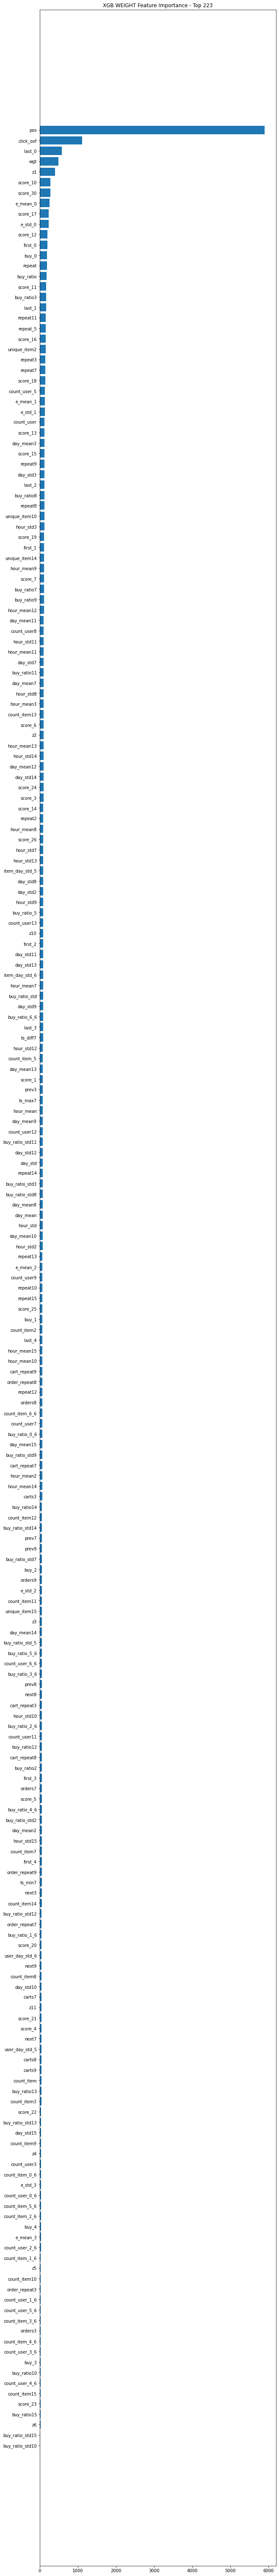

In [11]:
df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
#df.to_csv(f'feats_weight_{USE}_{VER}.csv',index=False)
NUM_FEATURES = len(df)
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB WEIGHT Feature Importance - Top {NUM_FEATURES}')
plt.show()

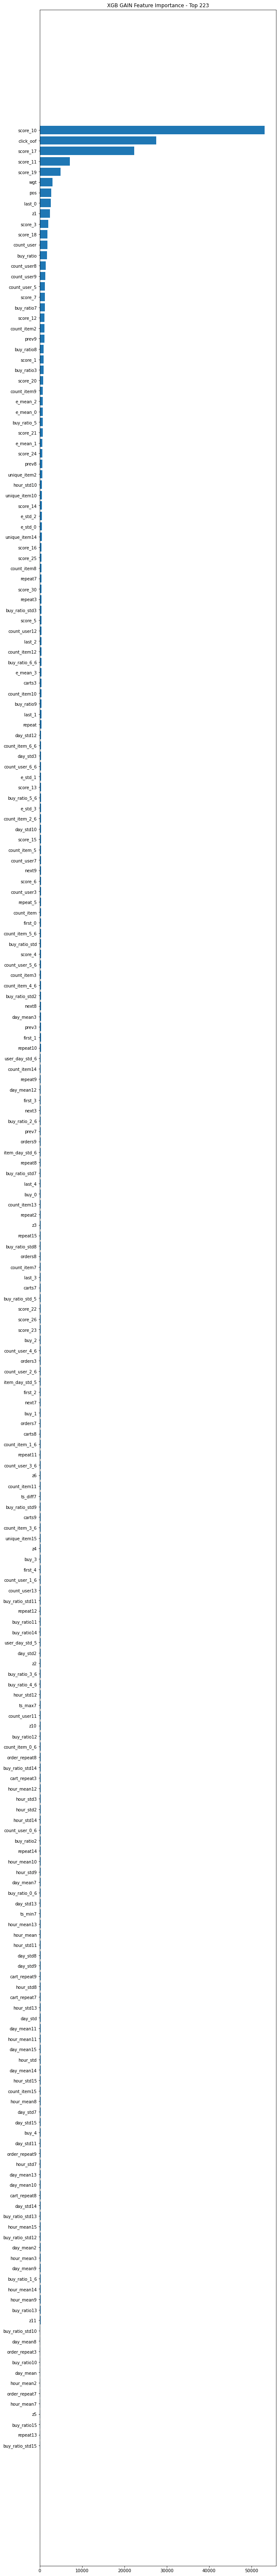

In [12]:
df = importances2[0].copy()
for k in range(1,FOLDS): df = df.merge(importances2[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'feats_gain_{USE}_{VER}.csv',index=False)
NUM_FEATURES = len(df)
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB GAIN Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Make Sub

In [13]:
sub = users[['user','item']].copy()
sub['p'] = oof
#sub = cudf.DataFrame(sub)
sub = sub.sort_values(['user','p'],ascending=[True,False])
print( sub.shape )
sub.head()

(23388700, 3)


,user,item,p
0,11098533,1165015,3.880280
3,11098533,1074173,2.798585
10,11098533,1309900,2.485724
2,11098533,978918,2.349761
6,11098533,1622419,2.141528


In [14]:
sub = sub.reset_index(drop=True)

In [15]:
sub['n'] = sub.groupby('user').item.cumcount().astype('int8')

In [16]:
sub.head()

,user,item,p,n
0,11098533,1165015,3.880280,0
1,11098533,1074173,2.798585,1
2,11098533,1309900,2.485724,2
3,11098533,978918,2.349761,3
4,11098533,1622419,2.141528,4


In [17]:
sub = sub.loc[sub.n<20]
print( sub.shape )

(4677740, 4)


In [18]:
#sub = sub.to_pandas()

In [19]:
%%time
sub2 = sub.groupby('user').item.apply(list)

CPU times: user 4.04 s, sys: 127 ms, total: 4.16 s
Wall time: 4.16 s


In [20]:
sub2 = sub2.to_frame().reset_index()

In [21]:
%%time
sub2.item = sub2.item.apply(lambda x: " ".join(map(str,x)))

CPU times: user 904 ms, sys: 30.7 ms, total: 934 ms
Wall time: 933 ms


In [22]:
sub2.columns = ['session_type','labels']

In [23]:
sub2.session_type = sub2.session_type.astype('str')+ f'_{USE}'

In [24]:
sub2.head()

,session_type,labels
0,11098533_carts,1165015 1074173 1309900 978918 1622419 765030 ...
1,11098534_carts,223062 908024 1607945 1449202 1342293 1300062 ...
2,11098538_carts,1263747 1550143 1317439 1172033 987426 1711586...
3,11098542_carts,1571098 1771977 1025387 594491 282630 13072 87...
4,11098543_carts,1168557 1458173 986294 1039959 114619 814145 1...


In [25]:
submission = sub2

In [26]:
def fill_up(x):
    return []

In [27]:
%%time
submission['session'] = submission.session_type.apply(lambda x: int(x.split('_')[0]))
submission['type'] = submission.session_type.apply(lambda x: x.split('_')[1])
submission.labels = submission.labels.apply(lambda x: [int(i) for i in x.split(' ')[:20]])

test_labels = pd.read_parquet('/raid/Kaggle/otto/valid/test_labels.parquet')
test_labels = test_labels.loc[test_labels['type']==USE]

test_labels = test_labels.merge(submission, how='left', on=['session', 'type'])
test_labels.loc[test_labels.labels.isna(),'labels'] =\
    test_labels.loc[test_labels.labels.isna(),'labels'].map(fill_up)

test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0,20)

recall_per_type = test_labels.groupby(['type'])['hits'].sum() / test_labels.groupby(['type'])['gt_count'].sum() 

score = (recall_per_type * pd.Series({'clicks': 0.10, 'carts': 0.30, 'orders': 0.60})).sum()
print( score , recall_per_type)

# carts    0.440095 v405 best
# carts    0.441119 v405 with giba

0.13243709257184091 type
carts    0.441457
dtype: float64
CPU times: user 10.2 s, sys: 274 ms, total: 10.5 s
Wall time: 10.2 s


In [28]:
0.3*0.435922 + 0.1*0.551342 + 0.6*0.665608

0.5852755999999999

In [1]:
0.3*0.441457 + 0.6*0.669116 + 0.1*0.5583575

0.58974245